#### Dropout and L2 regularization

In this unit, we will learn about dropout as an efficient regularization technique to reduce overfitting in neural networks. In the second part of the unit, we will also see how to implement 
L
2
 regularization using TensorFlow.

#### Dropout
The idea behind dropout is to randomly deactivate some neurons during the training. Here is an illustration of dropout applied to the hidden layer of a 2-layer neural network.



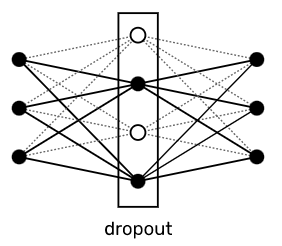

In [1]:
from IPython.display import Image
Image(filename='dropout.png')

This image shows dropout applied with a rate of 0.5 which means that the network randomly deactivate half of the neurons (in white) from the hidden layer at each training step. That way, the neurons in the output layer cannot learn complex rules that depend on all the neurons from the hidden layer.

Let’s see how to apply dropout to the network from the previous unit.

#### TensorFlow implementation
First, we load the data from the mnist-20k.npz archive, split it into train and validation sets and standardize it using a StandardScaler. We will also use get_batches() function from the previous unit.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load data
with np.load("c4_mnist-20k.npz", allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())

# Create train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    # Convert uint8 pixel values to float
    mnist["data"].astype(np.float32),
    mnist["labels"],
    test_size=500,
    random_state=0,
)

# Rescale input data
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_valid_rescaled = scaler.transform(X_valid)

# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y))  # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i : i + batch_size]
        yield X[batch_idx], y[batch_idx]


Let’s now define our layers. This time, we will try to improve our results by increasing the number of hidden units to 64 while avoiding overfitting using dropout.

In [3]:
import tensorflow as tf

# Define hidden layer with 64 units
hidden_layer = tf.keras.layers.Dense(
    units=64,
    activation=tf.nn.relu,  # ReLU
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=2, distribution="truncated_normal", seed=0
    ),
    bias_initializer=tf.zeros_initializer(),
    name="hidden",
)

# Define dropout layer (drop 25% of the neuron)
dropout_layer = tf.keras.layers.Dropout(rate=0.25, seed=0, name="dropout")

# Define output layer
logits_layer = tf.keras.layers.Dense(
    units=10,
    activation=None,  # No activation function
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1, distribution="truncated_normal", seed=0
    ),
    bias_initializer=tf.zeros_initializer(),
    name="output",
)

We have applied dropout to the hidden layer with the Dropout() class from the keras.layers module.

In [4]:
# Compute logits
hidden_output = hidden_layer(X_train_rescaled)
dropout_output = dropout_layer(hidden_output, training=False)  # do noting
# dropout_output = dropout_layer(hidden_output,training=True) # training, dropout activated
logits_output = logits_layer(dropout_output)

The dropout layer takes the tensor of output values, the dropout rate and a seed number to get deterministic results. Again, dropout is a method to reduce overfitting during the training process. In particular, we want to deactivate it when using the network to predict some values. To achieve this, we pass a boolean training parameter which indicates when we are training the network and when not.

The rest of the code is similar to what we saw in the previous unit.

In [5]:
# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

# Define functions used to train the graph

# Compute the logits
@tf.function
def compute_logits(x, training):
    hidden_output = hidden_layer(x)
    dropout_output = dropout_layer(hidden_output, training=training)
    logits = logits_layer(dropout_output)
    return logits


# Compute the loss
@tf.function
def compute_loss(y, logits):
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_ce = tf.reduce_mean(ce)
    return mean_ce


# Compute the accuracy
@tf.function
def compute_accuracy(y, logits):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    return acc


# Train the model (optimization procedure)
@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        logits = compute_logits(x, training=True)
        loss = compute_loss(y, logits)
    # Concatenate the trainable variables in one list using the '+' operation on lists
    variables = hidden_layer.trainable_variables + logits_layer.trainable_variables
    optimizer.minimize(loss=loss, var_list=variables, tape=tape)
    return logits, loss

#### Training
We can now train the network using the code from the previous unit. This time, we set training parameter of the dropout layer to True when running the training operation and set it to False when evaluating the validation accuracy.

In [6]:
# Train and validation accuracy after each epoch
train_acc_values = []
valid_acc_values = []

# Set seed
np.random.seed(0)

# Train several epochs
for epoch in range(50):
    # Accuracy values (train) after each batch
    batch_acc = []

    # Get batches of data
    for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 256):
        # Run training
        batch_logits, _ = train(X_batch, y_batch)

        # Evaluate training accuracy (on current batch)
        acc = compute_accuracy(y_batch, batch_logits)
        batch_acc.append(acc)

    # Evaluate validation accuracy (on the whole data)
    valid_logits = compute_logits(X_valid_rescaled, training=False)
    valid_acc = compute_accuracy(y_valid, valid_logits)
    valid_acc_values.append(valid_acc)

    # Also save train accuracy on the whole data (we will use the mean batch score in each epoch)
    train_acc_values.append(np.mean(batch_acc))

    # Print progress
    print(
        "Epoch {} - valid: {:.3f} train: {:.3f} (mean)".format(
            epoch + 1, valid_acc, np.mean(batch_acc)
        )
    )

Epoch 1 - valid: 0.914 train: 0.752 (mean)
Epoch 2 - valid: 0.934 train: 0.870 (mean)
Epoch 3 - valid: 0.936 train: 0.892 (mean)
Epoch 4 - valid: 0.952 train: 0.907 (mean)
Epoch 5 - valid: 0.948 train: 0.915 (mean)
Epoch 6 - valid: 0.956 train: 0.921 (mean)
Epoch 7 - valid: 0.950 train: 0.923 (mean)
Epoch 8 - valid: 0.960 train: 0.930 (mean)
Epoch 9 - valid: 0.956 train: 0.934 (mean)
Epoch 10 - valid: 0.952 train: 0.937 (mean)
Epoch 11 - valid: 0.960 train: 0.939 (mean)
Epoch 12 - valid: 0.958 train: 0.942 (mean)
Epoch 13 - valid: 0.958 train: 0.941 (mean)
Epoch 14 - valid: 0.958 train: 0.948 (mean)
Epoch 15 - valid: 0.958 train: 0.948 (mean)
Epoch 16 - valid: 0.956 train: 0.949 (mean)
Epoch 17 - valid: 0.956 train: 0.951 (mean)
Epoch 18 - valid: 0.958 train: 0.954 (mean)
Epoch 19 - valid: 0.962 train: 0.954 (mean)
Epoch 20 - valid: 0.962 train: 0.956 (mean)
Epoch 21 - valid: 0.962 train: 0.957 (mean)
Epoch 22 - valid: 0.962 train: 0.957 (mean)
Epoch 23 - valid: 0.962 train: 0.958 (mea

This time, the training accuracy has slightly improved compared to the previous unit. More importantly, the gap between the training and validation accuracy has shrunk and we were able to mitigate the overfitting. You can try to increase the dropout rate and notice the effect on both accuracies. With higher dropout rate, e.g. 0.5, the training accuracy might lag behind the validation accuracy (underfitting). This makes sense since the network has access to a smaller portion of the hidden units.

Let’s plot the validation accuracy after each epoch.



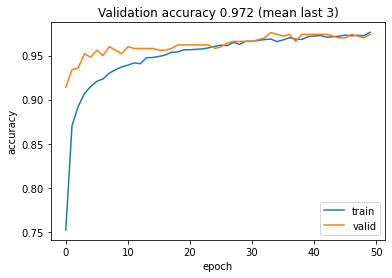

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(train_acc_values, label="train")
plt.plot(valid_acc_values, label="valid")
plt.title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(valid_acc_values[-3:])  # last three values
    )
)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In practice, it’s common to use slightly larger networks than necessary and then reduce overfitting using dropout. In our case, we have a small network with only 64 hidden units. For this reason, we don’t get huge improvements. However, try to remove dropout by setting training to False in the train() function. You should see that the training accuracy is above 99.9% after 50 epochs while the validation accuracy stays around 97%.

Let’s remind ourselves again what we saw in the previous unit by plotting the kernels of the first 16 hidden units with the following command.



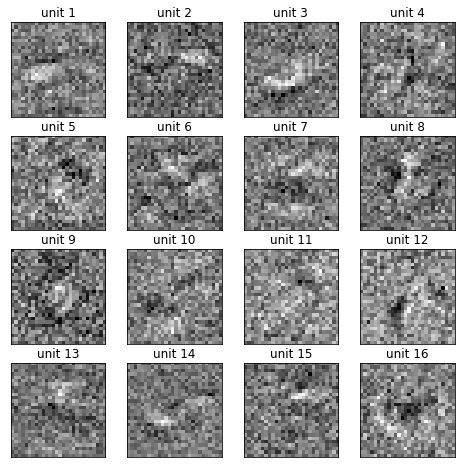

In [8]:
# Extract weights of the hidden layer
W1 = hidden_layer.kernel

# Plot first 16 kernels
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the weights of the first 16 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = W1[:, i].numpy()

    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)

    # Plot weights
    axis.set_title("unit {}".format(i + 1))
    axis.imshow(weights, cmap=plt.cm.gray_r)  # Grayscale
    axis.get_xaxis().set_visible(False)  # Disable x-axis
    axis.get_yaxis().set_visible(False)  # Disable y-axis

plt.show()

#### L2 regularization
We can also reduce overfitting by adding an 
L
2
 regularization term to the loss function using l2_loss() from the the nn module.

Let’s reinitialize the layers and rebuild our network by adjusting the loss function.

In [10]:
# Reinitialize the layers
hidden_layer = tf.keras.layers.Dense(
    units=64,
    activation=tf.nn.relu,  # ReLU
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=2, distribution="truncated_normal", seed=0
    ),
    bias_initializer=tf.zeros_initializer(),
    name="hidden",
)

dropout_layer = tf.keras.layers.Dropout(rate=0.25, seed=0, name="dropout")

logits_layer = tf.keras.layers.Dense(
    units=10,
    activation=None,  # No activation function
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1, distribution="truncated_normal", seed=0
    ),
    bias_initializer=tf.zeros_initializer(),
    name="output",
)

In [11]:
# Reinitialize gradient descent and decrease the learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)  #

# Compute the logits
@tf.function
def compute_logits(x, training):
    hidden_output = hidden_layer(x)
    dropout_output = dropout_layer(hidden_output, training=training)
    logits = logits_layer(dropout_output)
    return logits


# Redefine the loss function with L2 regularization
@tf.function
def compute_loss(y, logits):
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_ce = tf.reduce_mean(ce)

    # L2 term
    l2_term = tf.nn.l2_loss(hidden_layer.kernel)  # W1

    # Regularization strength
    alpha = 0.1

    loss = mean_ce + alpha * l2_term
    return loss


# Compute the accuracy
@tf.function
def compute_accuracy(y, logits):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    return acc


# Train the model (optimization procedure)
@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        logits = compute_logits(x, training=True)
        loss = compute_loss(y, logits)
    # Concatenate the trainable variables in one list using the '+' operation on lists
    variables = hidden_layer.trainable_variables + logits_layer.trainable_variables
    optimizer.minimize(loss=loss, var_list=variables, tape=tape)
    return logits, loss

In the code from above, we compute an l2_term and create an alpha parameter to control the regularization strength.

Let’s re-train our network using the code from above.



In [12]:
# Train and validation accuracy after each epoch
train_acc_values = []
valid_acc_values = []

# Set seed
np.random.seed(0)

# Train several epochs
for epoch in range(50):
    # Accuracy values (train) after each batch
    batch_acc = []

    # Get batches of data
    for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 256):
        # Run training
        batch_logits, _ = train(X_batch, y_batch)

        # Evaluate training accuracy (on current batch)
        acc = compute_accuracy(y_batch, batch_logits)
        batch_acc.append(acc)

    # Evaluate validation accuracy (on the whole data)
    valid_logits = compute_logits(X_valid_rescaled, training=False)
    valid_acc = compute_accuracy(y_valid, valid_logits)
    valid_acc_values.append(valid_acc)

    # Also save train accuracy on the whole data (we will use the mean batch score in each epoch)
    train_acc_values.append(np.mean(batch_acc))

    # Print progress
    print(
        "Epoch {} - valid: {:.3f} train: {:.3f} (mean)".format(
            epoch + 1, valid_acc, np.mean(batch_acc)
        )
    )

# Extract weights of the hidden layer
W1 = hidden_layer.kernel

Epoch 1 - valid: 0.664 train: 0.395 (mean)
Epoch 2 - valid: 0.790 train: 0.672 (mean)
Epoch 3 - valid: 0.826 train: 0.753 (mean)
Epoch 4 - valid: 0.866 train: 0.797 (mean)
Epoch 5 - valid: 0.876 train: 0.817 (mean)
Epoch 6 - valid: 0.890 train: 0.834 (mean)
Epoch 7 - valid: 0.904 train: 0.845 (mean)
Epoch 8 - valid: 0.912 train: 0.855 (mean)
Epoch 9 - valid: 0.914 train: 0.863 (mean)
Epoch 10 - valid: 0.914 train: 0.871 (mean)
Epoch 11 - valid: 0.920 train: 0.874 (mean)
Epoch 12 - valid: 0.922 train: 0.879 (mean)
Epoch 13 - valid: 0.922 train: 0.884 (mean)
Epoch 14 - valid: 0.924 train: 0.887 (mean)
Epoch 15 - valid: 0.930 train: 0.889 (mean)
Epoch 16 - valid: 0.928 train: 0.890 (mean)
Epoch 17 - valid: 0.930 train: 0.893 (mean)
Epoch 18 - valid: 0.930 train: 0.896 (mean)
Epoch 19 - valid: 0.930 train: 0.897 (mean)
Epoch 20 - valid: 0.934 train: 0.900 (mean)
Epoch 21 - valid: 0.936 train: 0.902 (mean)
Epoch 22 - valid: 0.934 train: 0.901 (mean)
Epoch 23 - valid: 0.932 train: 0.902 (mea

This time, we get an validation accuracy around 93%.



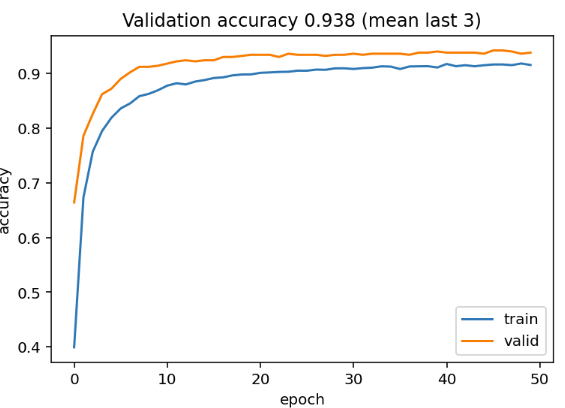

In [13]:
Image(filename='accuracy.png')

We can now take a look at a few hidden units using the tuned matrix of weights W1. We will plot the first 16 hidden units from the total 64 hidden units.

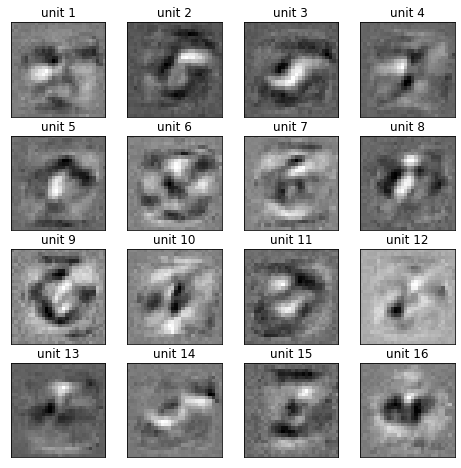

In [14]:
# Plot first 16 kernels
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the weights of the first 16 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = W1[:, i].numpy()

    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)

    # Plot weights
    axis.set_title("unit {}".format(i + 1))
    axis.imshow(weights, cmap=plt.cm.gray_r)  # Grayscale
    axis.get_xaxis().set_visible(False)  # Disable x-axis
    axis.get_yaxis().set_visible(False)  # Disable y-axis

plt.show()

As we can see, the templates of the hidden layer are much less noisy than what we have seen in the first unit.

#### Summary
In this unit, we saw how to reduce overfitting in our neural networks using dropout and 
L
2
 regularization. In the next one, we will learn about convolutional neural networks (CNN) which work really well to analyze images.